In [1]:
import pandas as pd 
import sklearn
import seaborn as sea
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

## Load in the data

In [2]:
house_prices_train = pd.read_csv('train.csv')
house_prices_test = pd.read_csv('test.csv')
house_prices_train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [3]:
house_prices_train.shape, house_prices_test.shape

((1460, 81), (1459, 80))

In [4]:
train = pd.read_csv('train_engineered2.csv')
test = pd.read_csv('test_engineered2.csv')
output = pd.read_csv('log_SalePrice2.csv', header=None)
output.rename(columns={0: "log_SalePrice"}, inplace=True)
output.head(2)
print train.shape, test.shape, output.shape

(1460, 299) (1459, 299) (1460, 1)


## Gradient Boosting

In [5]:
#Import libraries:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Performing grid search
from sklearn.grid_search import RandomizedSearchCV

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

### Function to fit model and do Cross Validation for error calculation

In [6]:
def modelfit(model, dtrain, features, output, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    model.fit(dtrain[features], output)
        
    #Predict training set:
    dtrain_predictions = model.predict(dtrain[features])
    #dtrain_predprob = model.predict_proba(dtrain[features])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(model, dtrain[features], output, cv=cv_folds)
    
    #Print model report:
    print "\nModel Report"
    print "R-Square: %.3f" % metrics.r2_score(output, dtrain_predictions)
    print "RMSE : %.3f" % np.sqrt(metrics.mean_squared_error(output, dtrain_predictions))
    print"cv_score: "
    print(cv_score)

    if performCV:
        print "CV Score : Mean: %.7g | Std: %.7g | Min: %.7g | Max: %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(model.feature_importances_[0:30], features[0:30]).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Top 30 Feature Importances')
        plt.ylabel('Features Importance Score')

### Baseline Model

(1460, 299) (1460, 1)

Model Report
R-Square: 0.959
RMSE : 0.081
cv_score: 
[ 0.90822756  0.88954213  0.8955057   0.90394005  0.89684149]
CV Score : Mean: 0.8988114 | Std: 0.006568024 | Min: 0.8895421 | Max: 0.9082276


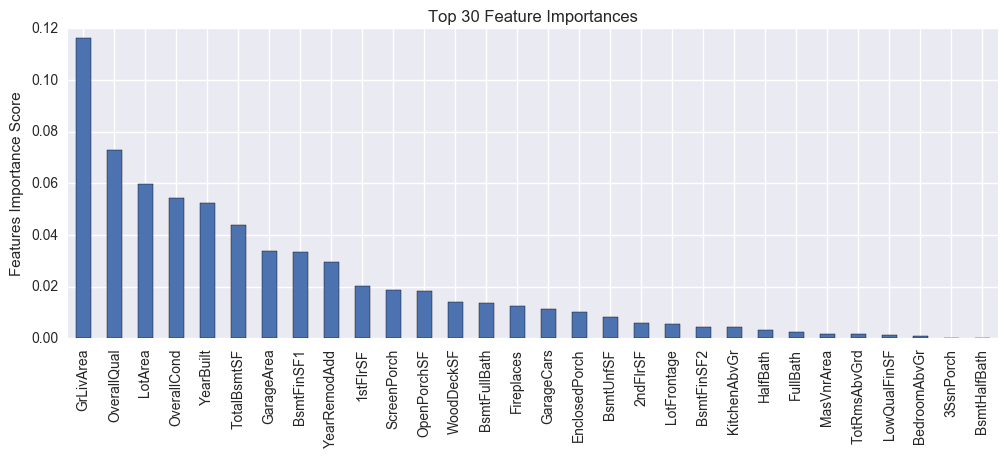

In [7]:
#features = [x for x in train.columns if x not in ['SalePrice', 'log_SalePrice']]
features = train.columns
print train[features].shape, output.shape
#print output
gbm = GradientBoostingRegressor(random_state=10)
modelfit(gbm, train, features, output, performCV=True, printFeatureImportance=True)

Mean CV score is 0.9006 and we should be able to do better so lets keep going!

### Parameter Tuning

In [8]:
min_samples_split = 0.01  #This should be ~0.5-1% of total values. 
min_samples_leaf = 50 #Can be selected based on intuition. This is just used for preventing overfitting 
max_depth = 3
max_features = 'sqrt' #Its a general thumb-rule to start with square root.
subsample = 0.8 #This is a commonly used used start value
learning_rate=0.3

In [9]:
param_test1 = {'n_estimators': range(20,501,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=learning_rate, min_samples_split=min_samples_split, 
                                                              min_samples_leaf=min_samples_leaf,max_depth=max_depth,
                                                              max_features=max_features,
                                                              subsample=subsample,random_state=10), 
                                                              param_grid = param_test1, n_jobs=4,iid=False,cv=5)

In [10]:
gsearch1.fit(train[features], output)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.3, loss='ls',
             max_depth=3, max_features='sqrt', max_leaf_nodes=None,
             min_samples_leaf=50, min_samples_split=0.01,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=10, subsample=0.8, verbose=0,
             warm_start=False),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [11]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.84051, std: 0.01174, params: {'n_estimators': 20},
  mean: 0.85283, std: 0.01238, params: {'n_estimators': 30},
  mean: 0.85958, std: 0.01247, params: {'n_estimators': 40},
  mean: 0.86165, std: 0.01129, params: {'n_estimators': 50},
  mean: 0.86377, std: 0.01157, params: {'n_estimators': 60},
  mean: 0.86504, std: 0.01095, params: {'n_estimators': 70},
  mean: 0.86605, std: 0.00991, params: {'n_estimators': 80},
  mean: 0.86676, std: 0.00946, params: {'n_estimators': 90},
  mean: 0.86820, std: 0.01034, params: {'n_estimators': 100},
  mean: 0.86773, std: 0.01057, params: {'n_estimators': 110},
  mean: 0.86807, std: 0.01060, params: {'n_estimators': 120},
  mean: 0.86806, std: 0.00958, params: {'n_estimators': 130},
  mean: 0.86842, std: 0.00977, params: {'n_estimators': 140},
  mean: 0.86862, std: 0.01001, params: {'n_estimators': 150},
  mean: 0.86841, std: 0.00955, params: {'n_estimators': 160},
  mean: 0.86867, std: 0.00982, params: {'n_estimators': 170},
  mean: 0.86924,

### Tuning tree-specific parameters

Now lets move onto tuning the tree parameters. I plan to do this in following stages:

Tune max_depth and num_samples_split
Tune min_samples_leaf
Tune max_features

In [12]:
gsearch1.best_params_['n_estimators']

230

In [13]:
param_test2 = {'max_depth': range(1,16,2), 'min_samples_split': np.arange(0.001, 0.011, 0.001)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=learning_rate, 
                                                              n_estimators=gsearch1.best_params_['n_estimators'], 
                                                              max_features=max_features, 
                                                              min_samples_leaf=min_samples_leaf, 
                                                              subsample=subsample, random_state=10), 
                                                    param_grid = param_test2 ,n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[features],output)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.001, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.002, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0030000000000000001, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0040000000000000001, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0050000000000000001, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0060000000000000001, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0070000000000000001, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0080000000000000002, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.0090000000000000011, 'max_depth': 1},
  mean: 0.87768, std: 0.01293, params: {'min_samples_split': 0.010000000000000002, 'max_depth': 1},
  mean: 0.87066, std: 0

In [14]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = min_samples_leaf 
max_depth = gsearch2.best_params_['max_depth']
max_features = 'sqrt'
subsample = subsample
n_estimators=gsearch1.best_params_['n_estimators'] 
learning_rate=learning_rate

In [15]:
param_test3 = {'min_samples_leaf':range(10,30,1), 'max_features':range(7,30,1)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                              min_samples_split=min_samples_split,max_depth=max_depth, 
                                                              subsample=0.8, random_state=10), 
                                                param_grid = param_test3, n_jobs=4, iid=False, cv=5)
gsearch3.fit(train[features], output)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.86921, std: 0.00771, params: {'max_features': 7, 'min_samples_leaf': 10},
  mean: 0.87009, std: 0.00716, params: {'max_features': 7, 'min_samples_leaf': 11},
  mean: 0.87079, std: 0.00732, params: {'max_features': 7, 'min_samples_leaf': 12},
  mean: 0.87040, std: 0.00671, params: {'max_features': 7, 'min_samples_leaf': 13},
  mean: 0.87069, std: 0.00629, params: {'max_features': 7, 'min_samples_leaf': 14},
  mean: 0.87022, std: 0.00726, params: {'max_features': 7, 'min_samples_leaf': 15},
  mean: 0.86988, std: 0.00636, params: {'max_features': 7, 'min_samples_leaf': 16},
  mean: 0.87066, std: 0.00744, params: {'max_features': 7, 'min_samples_leaf': 17},
  mean: 0.87142, std: 0.00830, params: {'max_features': 7, 'min_samples_leaf': 18},
  mean: 0.87173, std: 0.00839, params: {'max_features': 7, 'min_samples_leaf': 19},
  mean: 0.87210, std: 0.00908, params: {'max_features': 7, 'min_samples_leaf': 20},
  mean: 0.87166, std: 0.00904, params: {'max_features': 7, 'min_samples_leaf

#### Optimum parameters so far: 

In [16]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = gsearch3.best_params_['min_samples_leaf'] 
max_depth = gsearch2.best_params_['max_depth']
max_features = gsearch3.best_params_['max_features']
subsample = subsample
n_estimators=gsearch1.best_params_['n_estimators'] 
learning_rate=learning_rate


Model Report
R-Square: 0.911
RMSE : 0.119
cv_score: 
[ 0.90533474  0.88376059  0.88853011  0.88780808  0.87329852]
CV Score : Mean: 0.8877464 | Std: 0.01034017 | Min: 0.8732985 | Max: 0.9053347


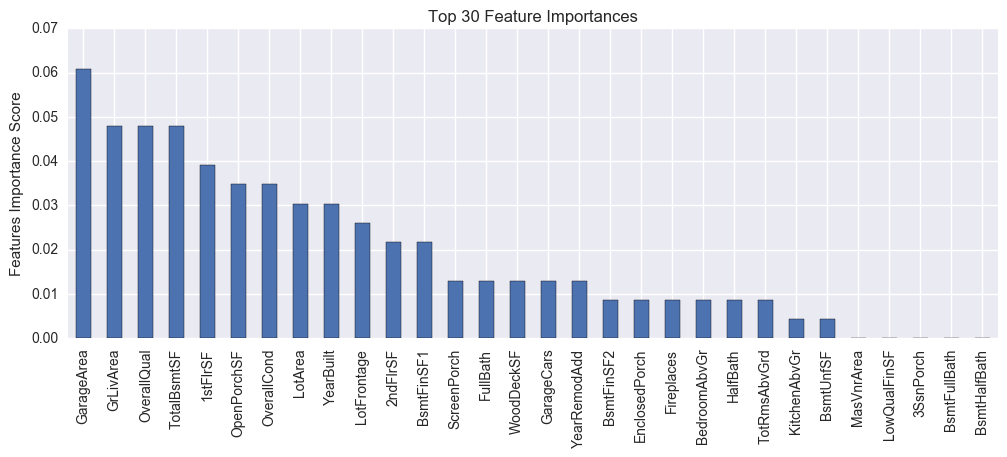

In [17]:
modelfit(gsearch3.best_estimator_, train, features, output)

If you compare the feature importance of this model with the baseline model, you’ll find that now we are able to derive value from many more variables. CV Score has gone down and RMSE has gone up, no performance is not as good as baseline model! This could be due to higher learning rate used so lets tune that down!

#### Lets tune subsample

In [18]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9, 0.95, 1.0]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                                               max_depth=max_depth,min_samples_split=min_samples_split, 
                                                               min_samples_leaf=min_samples_leaf, random_state=10,
                                                               max_features=max_features),
                                                param_grid = param_test5,n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[features],output)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.88069, std: 0.01277, params: {'subsample': 0.6},
  mean: 0.88308, std: 0.00852, params: {'subsample': 0.7},
  mean: 0.88371, std: 0.01045, params: {'subsample': 0.75},
  mean: 0.88775, std: 0.01034, params: {'subsample': 0.8},
  mean: 0.88460, std: 0.01117, params: {'subsample': 0.85},
  mean: 0.88579, std: 0.01252, params: {'subsample': 0.9},
  mean: 0.88383, std: 0.00841, params: {'subsample': 0.95},
  mean: 0.88241, std: 0.01204, params: {'subsample': 1.0}],
 {'subsample': 0.8},
 0.88774640906660385)

#### Lets decrease learning rate by half and double the number of trees

In [19]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = gsearch3.best_params_['min_samples_leaf'] 
max_depth = gsearch2.best_params_['max_depth']
max_features = gsearch3.best_params_['max_features']
subsample = gsearch5.best_params_['subsample']
n_estimators=gsearch1.best_params_['n_estimators']*2
learning_rate=learning_rate/2


Model Report
R-Square: 0.920
RMSE : 0.113
cv_score: 
[ 0.90442126  0.88588594  0.89119076  0.90510166  0.87770267]
CV Score : Mean: 0.8928605 | Std: 0.01062722 | Min: 0.8777027 | Max: 0.9051017


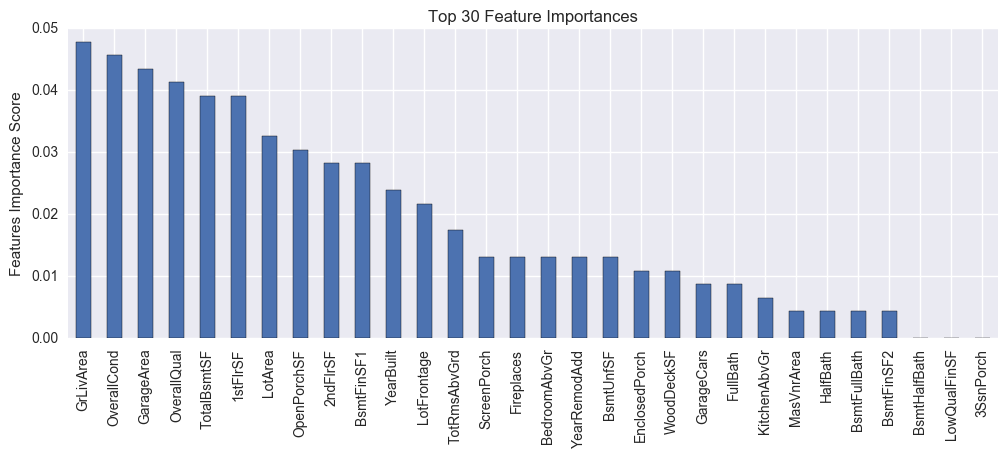

In [20]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_1, train, features, output)

#### Lets further decrease learning rate by half and increase the number of trees

In [21]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = gsearch3.best_params_['min_samples_leaf'] 
max_depth = gsearch2.best_params_['max_depth']
max_features = gsearch3.best_params_['max_features']
subsample = gsearch5.best_params_['subsample']
n_estimators=gsearch1.best_params_['n_estimators']*2
learning_rate=learning_rate/2


Model Report
R-Square: 0.911
RMSE : 0.119
cv_score: 
[ 0.90756531  0.88382542  0.88778602  0.90074468  0.87959742]
CV Score : Mean: 0.8919038 | Std: 0.01055564 | Min: 0.8795974 | Max: 0.9075653


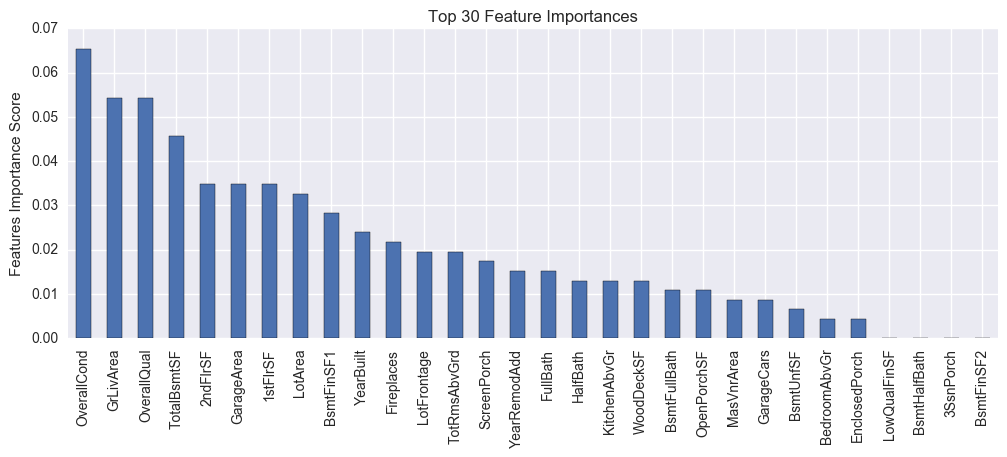

In [22]:
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_2, train, features, output)

#### Now lets reduce learning rate to one-tenth of the original value, i.e. 0.03 

In [23]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = gsearch3.best_params_['min_samples_leaf'] 
max_depth = gsearch2.best_params_['max_depth']
max_features = gsearch3.best_params_['max_features']
subsample = gsearch5.best_params_['subsample']
n_estimators=5000
learning_rate=0.03


Model Report
R-Square: 0.934
RMSE : 0.103
cv_score: 
[ 0.91489515  0.89122418  0.89779936  0.90962881  0.87936937]
CV Score : Mean: 0.8985834 | Std: 0.01274383 | Min: 0.8793694 | Max: 0.9148951


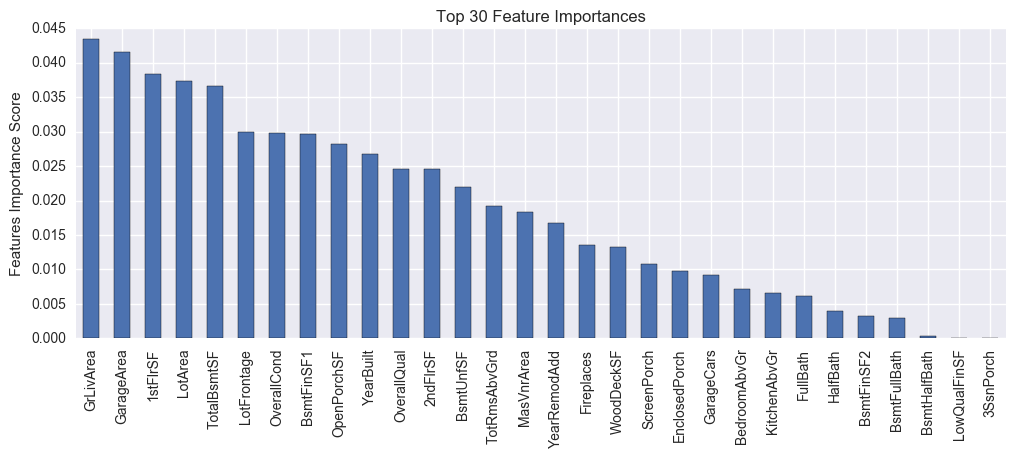

In [24]:
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_3, train, features, output)

#### Now lets reduce learning rate to 0.0015

In [31]:
min_samples_split = gsearch2.best_params_['min_samples_split'] 
min_samples_leaf = gsearch3.best_params_['min_samples_leaf'] 
max_depth = 3
max_features = gsearch3.best_params_['max_features']
subsample = gsearch5.best_params_['subsample']
n_estimators=30000
learning_rate=0.0015


Model Report
R-Square: 0.960
RMSE : 0.080
cv_score: 
[ 0.92231853  0.90291391  0.89985194  0.91622598  0.89556607]
CV Score : Mean: 0.9073753 | Std: 0.01017445 | Min: 0.8955661 | Max: 0.9223185


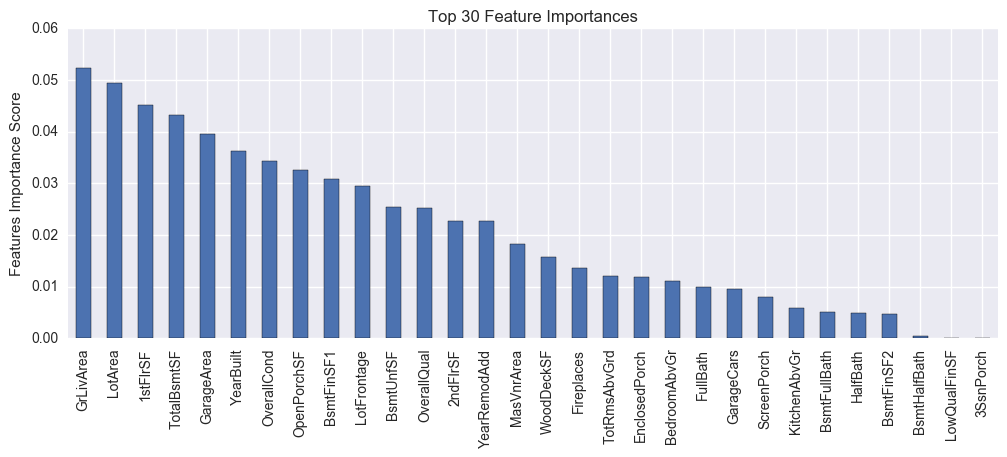

In [32]:
gbm_tuned_4 = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators,
                                        max_depth=max_depth, min_samples_split=min_samples_split,
                                        min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=10, 
                                        max_features=max_features)
modelfit(gbm_tuned_4, train, features, output)

In [33]:
pred = np.expm1(gbm_tuned_4.predict(test))
gbm_prediction = pd.DataFrame({'Id': house_prices_test['Id'], 'SalePrice': pred})
gbm_prediction.head(5)

,Id,SalePrice
0,1461,123304.913103
1,1462,160077.413654
2,1463,183636.734235
3,1464,197833.436599
4,1465,184311.231653


In [34]:
gbm_prediction.to_csv('kaggle_submission_gbm_01012017_2.csv', index=False)